# Deep Transformer


## Library

In [210]:
import torch
from torch import nn, einsum
from torch.nn.modules.linear import Linear
import torch.optim as optim
import torch.nn.functional as F
import math
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

## Model

Full Attention

In [211]:
def full_attention(query, key, value, causal=False, dropout=0.0):
    device = key.device
    B_k, h_k, n_k, d_k = key.shape
    B_q, h_q, n_q, d_q = query.shape

    scale = einsum("bhqd,bhkd->bhqk", query, key)/math.sqrt(d_k)

    if causal:
        ones = torch.ones(B_k, h_k, n_q, n_k).to(device)
        mask = torch.tril(ones)
        scale = scale.masked_fill(mask == 0, -1e9)
    atn = F.softmax(scale, dim=-1)
    if dropout is not None:
        atn = F.dropout(atn, p=dropout)
    out = einsum("bhqk,bhkd->bhqd", atn, value)
    return out

In [212]:
def to_eachhead(x, head_num, split_num=3):
    B, n, pre_d = x.shape
    new_d = pre_d//split_num
    assert pre_d%split_num == 0, f"have to be multiple of {split_num}"
    assert new_d%head_num == 0, "dim must be divided by head_num"

    tpl = torch.chunk(x, split_num, dim=2)
    out = []
    for t in tpl:
        out.append(t.reshape(B, n, head_num, new_d//head_num).transpose(1,2))
    return out

In [213]:
def concat_head(x):
    B, h, n, _d = x.shape
    out = x.transpose(1,2).reshape(B, n, _d*h)
    return out

Positional Encoding

In [214]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, #dropout: float = 0.1,
                 max_len: int = 100):
        super().__init__()
        # self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.squeeze(1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)]
        # return self.dropout(x)
        return x

Pre-layer

In [215]:
class PreLayer(nn.Module):
    def __init__(self, hid, d_model, drop_out=0.0, in_dim=1):
        super().__init__()
        # self.linear = nn.Linear(in_dim, d_model)
        self.linear1 = nn.Linear(in_dim, hid, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hid, d_model, bias=True)


    def forward(self, x):
        # out = self.linear(x)
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

Post-layer

In [216]:
class PostLayer(nn.Module):
    def __init__(self, dim, vocab_num, hid_dim, dropout_ratio):
        super().__init__()
        # self.linear = nn.Linear(dim, vocab_num)
        self.linear1 = nn.Linear(dim, hid_dim, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hid_dim, vocab_num, bias=True)
    def forward(self,x):
        # out = self.linear(x)
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

Multi-head Attention

1) Multi-head Self Attention

In [217]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, head_num):
        super().__init__()
        self.to_qvk = nn.Linear(dim, dim*3)
        self.make_head = partial(to_eachhead, head_num=head_num, split_num=3)
        self.mhsa = full_attention

    def forward(self, x):
        qvk = self.to_qvk(x)
        q, v, k = self.make_head(qvk)
        out = self.mhsa(q, k, v)
        out = concat_head(out)
        return out

2) Multi-head Causal Attention

In [218]:
class MultiHeadCausalAttention(nn.Module):
    def __init__(self, dim, head_num):
        super().__init__()
        self.to_qvk = nn.Linear(dim, dim*3)
        self.make_head = partial(to_eachhead, head_num=head_num, split_num=3)
        self.mhca = partial(full_attention, causal=True)

    def forward(self, x):
        qvk = self.to_qvk(x)
        q, v, k = self.make_head(qvk)
        out = self.mhca(q, k, v)
        out = concat_head(out)
        return out

3) Multi-head Source Attention

In [219]:
class MultiHeadSourceAttention(nn.Module):
    def __init__(self, dim, head_num):
        super().__init__()
        self.to_kv = nn.Linear(dim, dim*2)
        self.to_q = nn.Linear(dim, dim)
        self.make_head_kv = partial(to_eachhead, head_num=head_num, split_num=2)
        self.make_head_q = partial(to_eachhead, head_num=head_num, split_num=1)
        self.mhsa = full_attention

    def forward(self, x, memory):
        mem = self.to_kv(memory)
        x = self.to_q(x)
        k, v = self.make_head_kv(mem)
        q = self.make_head_q(x)[0]
        out = self.mhsa(q, k, v)
        out = concat_head(out)
        return out

Feed Fordward

In [220]:
class FeedForward(nn.Module):
    def __init__(self, dim, hid_dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, hid_dim, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hid_dim, dim, bias=True)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

Encoder

In [221]:
class EncoderLayer(nn.Module):
    def __init__(self, dim, head_num, ff_hidnum, dropout_ratio, norm_first=False):
        super().__init__()
        self.dor = dropout_ratio
        self.mhsa = MultiHeadSelfAttention(dim, head_num)
        self.ln1 = nn.LayerNorm(dim)
        self.ff = FeedForward(dim, ff_hidnum)
        self.ln2 = nn.LayerNorm(dim)
        self.norm_first = norm_first

    def forward(self, x):
        res = torch.clone(x)

        if self.norm_first:
          out = self.ln1(x)
          out = self.mhsa(out)
          out = F.dropout(out, p=self.dor) + res

          res = torch.clone(out)
          out = self.ln2(out)
          out = self.ff(out)
          out = F.dropout(out, p=self.dor) + res
        else:
          out = self.mhsa(x)
          out = F.dropout(out, p=self.dor) + res
          out = self.ln1(out)

          res = torch.clone(out)
          out = self.ff(out)
          out = F.dropout(out, p=self.dor) + res
          out = self.ln2(out)

        return out

In [222]:
class Encoder(nn.Module):
    def __init__(self, depth, dim, head_num, ff_hidnum=2048, dropout_ratio=0.2, norm_first=False):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(dim, head_num, ff_hidnum, dropout_ratio, norm_first) for i in range(depth)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Decoder

In [223]:
class DecoderLayer(nn.Module):
    def __init__(self, dim, head_num, ff_hidnum, dropout_ratio, norm_first=False):
        super().__init__()
        self.dor = dropout_ratio
        self.mhca = MultiHeadCausalAttention(dim, head_num)
        self.ln1 = nn.LayerNorm(dim)
        self.mhsa = MultiHeadSourceAttention(dim, head_num)
        self.ln2 = nn.LayerNorm(dim)
        self.ff = FeedForward(dim, ff_hidnum)
        self.ln3 = nn.LayerNorm(dim)
        self.norm_first = norm_first

    def forward(self, x, memory):
        res = torch.clone(x)

        if self.norm_first:
          out = self.ln1(x)
          out = self.mhca(out)
          out = F.dropout(out, p=self.dor) + res

          res = torch.clone(out)
          out = self.ln2(out)
          out = self.mhsa(out, memory)
          out = F.dropout(out, p=self.dor) + res

          res = torch.clone(out)
          out = self.ln3(out)
          out = self.ff(out)
          out = F.dropout(out, p=self.dor) + res

        else:
          out = self.mhca(x)
          out = F.dropout(out, p=self.dor) + res
          out = self.ln1(out)

          res = torch.clone(out)
          out = self.mhsa(out, memory)
          out = F.dropout(out, p=self.dor) + res
          out = self.ln2(out)

          res = torch.clone(out)
          out = self.ff(out)
          out = F.dropout(out, p=self.dor) + res
          out = self.ln3(out)

        return out

In [224]:
class Decoder(nn.Module):
    def __init__(self, depth, dim, head_num, ff_hidnum, dropout_ratio=0.2, norm_first=False):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(dim, head_num, ff_hidnum, dropout_ratio, norm_first) for i in range(depth)])

    def forward(self, x, memory):
        for layer in self.layers:
            x = layer(x, memory)
        return x

Transformer

In [225]:
class Transformer(nn.Module):
    def __init__(self, device, d_model, in_dim, N_enc, N_dec, h_enc, h_dec, ff_hidnum, hid_pre, hid_post, dropout_pre, dropout_post, dropout_model, norm_first=False):
        super().__init__()
        self.device = device
        self.x_pre = PreLayer(hid_pre, d_model, dropout_pre, in_dim)
        self.y_pre = PreLayer(hid_pre, d_model, dropout_pre, in_dim)
        self.pos = PositionalEncoding(d_model)
        self.enc = Encoder(N_enc,d_model, h_enc, ff_hidnum, dropout_model, norm_first)
        self.dec = Decoder(N_dec,d_model, h_dec, ff_hidnum, dropout_model, norm_first)
        self.post = PostLayer(d_model, 1, hid_post, dropout_post)

    def forward(self, x, y):
        x_emb = self.x_pre(x)
        y_emb = self.y_pre(y)
        x_emb_pos = self.pos(x_emb)
        y_emb_pos = self.pos(y_emb)
        memory = self.enc(x_emb_pos)
        out = self.dec(y_emb_pos, memory)
        out = self.post(out)
        out = out.squeeze(-1)
        return out

    def generate(self, x, forcast_step, y_start,multivariate=False):
        device = x.device
        x = x.to(device)
        B, N, D = x.shape
        x = self.x_pre(x) 
        x = self.pos(x)
        z = self.enc(x) 
        y = y_start
        for i in range(forcast_step):
            y_pred = self.y_pre(y)
            y_pred = self.pos(y_pred)
            y_pred = self.dec(y_pred, z)
            y_pred = self.post(y_pred)
            if multivariate:
                y = torch.cat([y, y_pred[:,[-1],:]], dim=2)
            else:
                y = torch.cat([y, y_pred[:,[-1],:]], dim=1)
        y_pred = y_pred.squeeze(-1)
        return y_pred

## Dataset

In [226]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, input_step, predict_step):
        super().__init__()
        self.data = data
        self.predict_step = predict_step
        self.input_step = input_step
        self.start_max = self.data.shape[0] - (self.predict_step + self.input_step) + 1
        self.datalen = self.start_max

    def __len__(self):
        return self.datalen

    def __getitem__(self, idx):
        start_idx = idx % self.start_max
        predict_idx = start_idx + self.input_step
        end_idx = predict_idx + self.predict_step

        x = self.data[start_idx:predict_idx, :]
        y = self.data[predict_idx-1:end_idx-1, :]
        tgt = self.data[predict_idx:end_idx, :]

        x = torch.from_numpy(x)
        y = torch.from_numpy(y)
        tgt = torch.from_numpy(tgt)

        return x, y, tgt

In [402]:
# data_path = 'https://data.covid19.go.id/public/api/update.json'
# data_path = 'update_22-3-2022.json'
import requests
import json
import pandas as pd

def load_data(data_path, dataset_len=None, test_size=30,multivariate=False):
    # data = requests.get(data_path).json() if from_api else pd.read_json(data_path)

    # data = pd.DataFrame(data['update']['harian'])[['key','jumlah_positif']]
    # data.key = pd.to_datetime(data.key, unit='ms')

    # data=pd.read_csv(data_path)
    # data=data[["V1","V2"]]
    # data = data.set_index('V1')

    # ETTm2
    # data=pd.read_csv(data_path)
    # data=data[["date","OT"]]
    # data = data.set_index('date')

    # Turbine Dataset
    data=pd.read_csv(data_path)
    data = data.rename(columns={data.columns[0]: 'Date'}) 
    data=data.dropna(subset=["ActivePower","WindSpeed"])
    # data=data[["Date","ActivePower","WindSpeed"]]
    data=data[["Date","ActivePower"]]
    data = data.set_index('Date')


    data_len = data.shape[0]
    if multivariate:
        numpy_use = data.to_numpy()
        original_data = data
        from sklearn.preprocessing import MinMaxScaler
        numpy_use_jii = data['ActivePower'].to_numpy()
        scaler = MinMaxScaler(feature_range=(-1, 1))
        numpy_use_jii = scaler.fit_transform(numpy_use_jii.reshape(-1,1))
        scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
        numpy_use = scaler_all.fit_transform(numpy_use)
        
        train_val, test_only = numpy_use[:data_len - test_size,:], numpy_use[data_len - test_size:,:]
        train_num = data_len//10 * 8
        train_data = train_val[:train_num].astype("float32")
        val_data = train_val[train_num:].astype("float32")
        test_data = test_only.astype("float32")
        return train_data, val_data, test_data, scaler, original_data
    else:
        numpy_use = data['ActivePower'].to_numpy()
        original_data = data["ActivePower"]
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(-1, 1)) 
        numpy_use = scaler.fit_transform(numpy_use.reshape(-1,1))
        
        train_val, test_only = numpy_use[:numpy_use.size - test_size], numpy_use[numpy_use.size - test_size:]
        train_num = data_len//10 * 8
        train_data = train_val[:train_num].astype("float32")
        val_data = train_val[train_num:].astype("float32")
        test_data = test_only.astype("float32")
        return train_data, val_data, test_data, scaler, original_data

In [403]:
def make_dataloader(train_data, val_data, test_data, input_step, predict_step, batch_size, shuffle_train=True, shuffle_val=False):
    train_set = Dataset(train_data, input_step, predict_step)
    val_set = Dataset(val_data, input_step, predict_step)
    test_set = Dataset(test_data, input_step, predict_step)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=shuffle_train)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=shuffle_val)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Training

Training Utils

In [404]:
def lr_func(step, d_model):
    warmup_steps = 5000
    step_term = min(step**0.5, step*warmup_steps**(-1.5))
    return d_model**0.5 * step_term

In [405]:
import random

def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [406]:
## Calculate MSE eval
def check_data(device, test_loader, net, criterion):
    net.eval()
    loss_log = []
    for iter, (x, y, tgt) in enumerate(test_loader):
        x, y, tgt = x.to(device), y.to(device), tgt.to(device)
        tgt = tgt[:,:,0]

        out = net(x, y)

        loss = criterion(out, tgt)
        loss_log.append(loss.item())

    return sum(loss_log)/len(loss_log)# MSE

In [358]:
import torch
import numpy as np
import os

In [407]:
torch.set_printoptions(precision=5, sci_mode=False)
np.set_printoptions(precision=5, suppress=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Hyper-parameter

In [408]:
input_step = 4
predict_step = 1
d_model = 64
batch_size = 1510
max_epoch = 1
in_dim = 1
N_enc = 1
N_dec = 1
h_enc = 1
h_dec = 1
ff_hidnum = 100
hid_pre = 100
hid_post =100
dropout_pre = 0
dropout_post = 0
dropout_model = 0
save_each = 10
multi=False
norm_first = False # default = False (Post-LN)
# dbg = args.debug
model_path = 'content/model/'
test_result_path = 'content/test_result_path/'

In [235]:
# dir_list = ["/content/model/","/content/test_result_path/"]

# for dir in dir_list:
#   if os.path.isdir(dir) != True:
#     os.mkdir(dir)

Load Data

In [409]:
train, val, test, scaler, original = load_data("Data/Turbine_Data.csv", test_size=120,multivariate=multi)
# train, val, test, scaler, original = load_data('update 12-05-2022.json', from_api=False,
#                                                          dataset_len=750, test_size=60)#input_step+predict_step+60)

In [410]:
train.shape, val.shape, test.shape

((75544, 1), (18772, 1), (120, 1))

In [411]:
train.size + val.size + test.size

94436

In [412]:
train_loader, val_loader, test_loader = make_dataloader(train, val, test, input_step, predict_step, batch_size, shuffle_train=False, shuffle_val=False)

## Manual Run

### Cosine Cyclic Learning Rate

In [365]:
from torch.optim.lr_scheduler import _LRScheduler
class CosineCyclicLR(_LRScheduler):
    def __init__(self, optimizer, base_lr, max_lr, step_size, last_epoch=-1):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        super(CosineCyclicLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        cycle = math.floor(1 + self.last_epoch / (2 * self.step_size))
        x = abs(self.last_epoch / self.step_size - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * (1 + math.cos(math.pi * x)) / 2
        # print(self.last_epoch,lr)
        return [lr for _ in self.base_lrs]

### Cosine Cyclic Learning Rate with Batch Variance

In [413]:
import math
from torch.optim.lr_scheduler import _LRScheduler
import pytorch_forecasting

class BatchVarCosineCyclicLR(_LRScheduler):
    def __init__(self, optimizer, base_lr, max_lr, step_size, last_epoch=-1):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.data = None
        super(BatchVarCosineCyclicLR, self).__init__(optimizer, last_epoch) 
    def get_lr(self):
        cycle = math.floor(1 + self.last_epoch / (2 * self.step_size))
        x = abs(self.last_epoch / self.step_size - 2 * cycle + 1)
        lr = [self.base_lr + (self.max_lr - self.base_lr) * (1 + math.cos(math.pi * x)) / 2 * (1 + self.get_batch_variance()) for _ in self.base_lrs]
        return lr
    def get_batch_variance(self):
        # AutoCorrelation+sigmoid
        if self.data is None:
            return 1
        step_var=[]
        for items in self.data:
            SGLayer = nn.Sigmoid()
            output=pytorch_forecasting.autocorrelation(items)
            output=torch.nan_to_num(output, nan=0)
            output=SGLayer(output)
            step_var.append(torch.var(output))
        tensor_batch_step_var = torch.tensor(step_var)
        mean_step=torch.mean(tensor_batch_step_var)
        batch_variance = mean_step.numpy()
        return batch_variance    
    def set_batch_data(self, data):
        self.data = data


In [414]:
    
def CorrSyncLR(base_lr, max_lr, step_size):
        step_var=[]
        for items in self.data:
            SGLayer = nn.Sigmoid()
            output=pytorch_forecasting.autocorrelation(items)
            output=torch.nan_to_num(output, nan=0)
            output=SGLayer(output)
            step_var.append(torch.var(output))
        tensor_batch_step_var = torch.tensor(step_var)
        mean_step=torch.mean(tensor_batch_step_var)
        batch_variance = mean_step.numpy()
        cycle = math.floor(1 + self.last_epoch / (2 * self.step_size))
        x = abs(self.last_epoch / self.step_size - 2 * cycle + 1)
        lr = [self.base_lr + (self.max_lr - self.base_lr) * (1 + math.cos(math.pi * x)) / 2 * (1 + self.get_batch_variance()) for _ in self.base_lrs]

In [415]:
for iter, (x, y, tgt) in enumerate(train_loader):
    print(x.shape)
    break

torch.Size([1510, 4, 1])


### Train

In [420]:
net = Transformer(device, d_model, in_dim, N_enc, N_dec, h_enc, h_dec, ff_hidnum, hid_pre, hid_post, dropout_pre, dropout_post, dropout_model, norm_first)
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr=0.0002782)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=partial(lr_func, d_model = d_model))

In [424]:
import matplotlib.pyplot as plt
import scipy

train_loss_log = []
val_loss_log = []

best_train_loss = np.inf
best_val_loss = np.inf
best_both_loss = (np.inf, np.inf)
best_train_epoch = 0
best_val_epoch = 0
best_both_epoch = 0
criterion = nn.MSELoss()

# buatcyclic 
base_lr=0.0002782559402207126
max_lr_multiplier=7
cycle_size=25
lrs=[]
bvs=[]

max_iteration = 0
for epoch in range(max_epoch):
  # scheduler = CosineCyclicLR(optimizer, base_lr=base_lr,max_lr=(base_lr*max_lr_multiplier), step_size=cycle_size)
  scheduler = BatchVarCosineCyclicLR(optimizer, base_lr=base_lr, max_lr=(base_lr*max_lr_multiplier), step_size=cycle_size)
  tgt_log_train = np.zeros((1,predict_step))
  pred_log_train = np.zeros((1,predict_step))

  for iter, (x, y, tgt) in enumerate(train_loader):
    x, y, tgt = x.to(device), y.to(device), tgt.to(device)
    
    tgt = tgt[:,:,0]
    net.train()
    scheduler.set_batch_data(x)  
      
    out = net(x, y)
    loss = criterion(out, tgt)
            
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    lrs.append(scheduler.get_last_lr())
    bvs.append(scheduler.get_batch_variance())
      
    out_npy = out.to('cpu').detach().numpy().copy()
    tgt_npy = tgt.to('cpu').detach().numpy().copy()

    pred_log_train = np.concatenate([pred_log_train, out_npy], axis=0)
    tgt_log_train = np.concatenate([tgt_log_train, tgt_npy], axis=0)   
  break

  if epoch == 0:
    max_iteration = iter + 1
  train_loss_log.append(loss.item())      
  val_loss = check_data(device, val_loader, net, criterion)
  val_loss_log.append(val_loss)# MSE
  print("epoch : {}, MSE loss : {}, RMSE loss : {}".format(epoch, loss.item(), torch.sqrt(loss).item()))
  # print("*************validation******************")
  print("val_loss : {}, rmse : {}\n".format(val_loss, math.sqrt(val_loss)))
  
  # save low train loss model
  if loss < best_train_loss:
    best_train_loss = loss
    best_train_epoch = epoch
    torch.save(net.state_dict(), os.path.join(model_path, "best_train_loss_model.model"))

  # save low val loss model
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_val_epoch = epoch
    torch.save(net.state_dict(), os.path.join(model_path, "best_val_loss_model.model"))
    
  # save both loss model
  if loss < best_train_loss and val_loss < best_val_loss:
    best_both_loss = (loss, val_loss)
    best_both_epoch = epoch
    torch.save(net.state_dict(), os.path.join(model_path, "best_both_loss_model.model"))

  # save model
  if epoch % save_each == 0 or epoch == max_epoch - 1:
    torch.save(net.state_dict(), os.path.join(model_path, '{}_epoch.model'.format(epoch)))

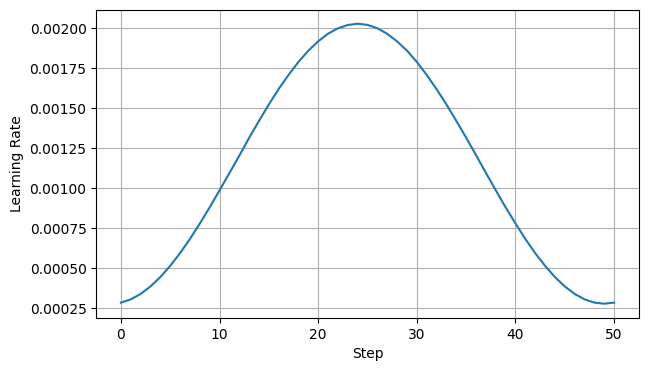

In [426]:
plt.figure(figsize=(7,4))
# plt.set_ylim(bottom=0.00001)
plt.grid(True)
plt.ylabel("Learning Rate")
plt.xlabel("Step")
# plt.ylim(ymin=0.0001)
plt.plot(lrs)

In [249]:
train_loss_np = np.array(train_loss_log)
val_loss_np = np.array(val_loss_log)

In [250]:
# from numpy import savetxt
# savetxt('saved_train_log/WIND_Konvensional.csv', val_loss_np4, delimiter=',')

In [251]:
# len(val_loss_np3[80:-1])
# len(range(80,99))

In [252]:
# # import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(15,6))
# # ax.plot(train_loss_np3, label="train")
# ax.plot(range(63, 100),val_loss_np1[63:], label="Deep Transformer dengan Sigmoid + Batch Auto Correlation Variance")
# ax.plot(range(63, 100),val_loss_np2[63:], label="Deep Transformer dengan Cyclic Leaning Rate")
# ax.plot(range(63, 100),val_loss_np4[63:], label="Deep Transformer Konvensional")
# # plt.xticks(range(80, 99)5)
# plt.xticks(ticks=range(63, 100, 1), labels=range(63, 100, 1))
# plt.legend()
# ax.set_xlabel("Epoch")
# ax.set_ylabel("Loss")
# plt.grid(True)

# plt.show()

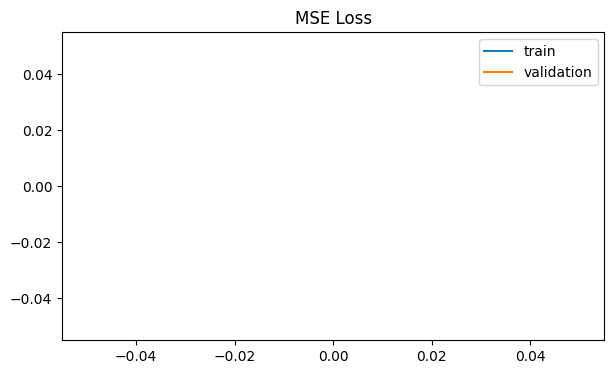

In [253]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(train_loss_np, label="train")
ax.plot(val_loss_np, label="validation")
plt.title("MSE Loss")
plt.legend()
plt.show()

In [254]:
best_train_epoch, best_val_epoch,best_val_loss

(0, 0, inf)

In [255]:
min_plot = best_val_epoch-10 if best_val_epoch >= 10 else 0
max_plot = best_val_epoch+10

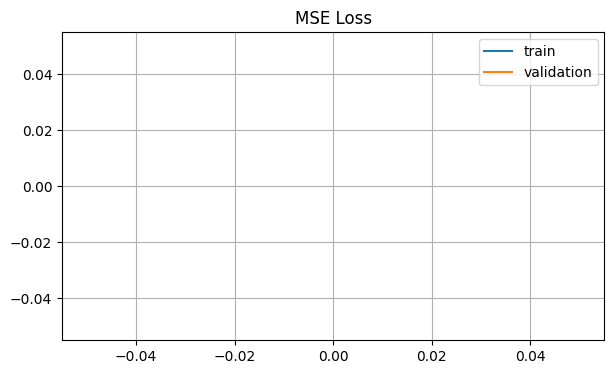

In [256]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(train_loss_np[min_plot:max_plot], label="train")
ax.plot(val_loss_np[min_plot:max_plot], label = "validation")
plt.title("MSE Loss")
plt.grid(which='both')
plt.legend()
plt.show()

### Testing

In [257]:
def make_dataloader(data, input_step, predict_step, batch_size=1):
    dataset = Dataset(data, input_step, predict_step)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataset, dataloader

In [258]:
torch.set_printoptions(precision=5, sci_mode=False)
np.set_printoptions(precision=5, suppress=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [259]:
test_set, test_loader = make_dataloader(test, input_step, predict_step, batch_size=600)
all_data = test_set.data[:,0]

In [260]:
test_set.data.shape

(120, 1)

In [261]:
test.size

120

In [262]:
epoch_num = best_val_epoch
print(epoch_num)
par_path = os.path.join(model_path, "best_val_loss_model.model")

0


In [ ]:
net = Transformer(device, d_model, in_dim, N_enc, N_dec, h_enc, h_dec, ff_hidnum, hid_pre, hid_post, dropout_pre, dropout_post, dropout_model, norm_first)
    
# load parameter
if device == torch.device("cpu"):
  net.load_state_dict(torch.load(par_path, map_location=torch.device("cpu")))
else:
  net.load_state_dict(torch.load(par_path,map_location=torch.device(device)))

In [ ]:
net.eval()

pred_list = np.zeros((1, predict_step))
for iter, (x, y, tgt) in enumerate(test_loader):
    tgt = tgt[:,:,0]

    out = net.generate(x, tgt.shape[1], y[:,[0],:],multi)
    out = out.to('cpu').detach().numpy().copy()

    pred_list = np.concatenate([pred_list, out], axis=0)

pred_list = pred_list[1:]
D = []
for i in range(predict_step):
    tmp = np.concatenate([all_data[:(input_step+i)], pred_list[:,i], all_data[(all_data.shape[0]-(predict_step - (i + 1))):]])
    D.append(tmp)

for step_num, tmp_data in enumerate(D):
    n = step_num + 1

    np.save(os.path.join(test_result_path, "pred{}_epoch{}".format(n, epoch_num)), pred_list[:,[step_num]])
    np.save(os.path.join(test_result_path, "tgt{}_epoch{}".format(n, epoch_num)), tgt[:,[step_num]])

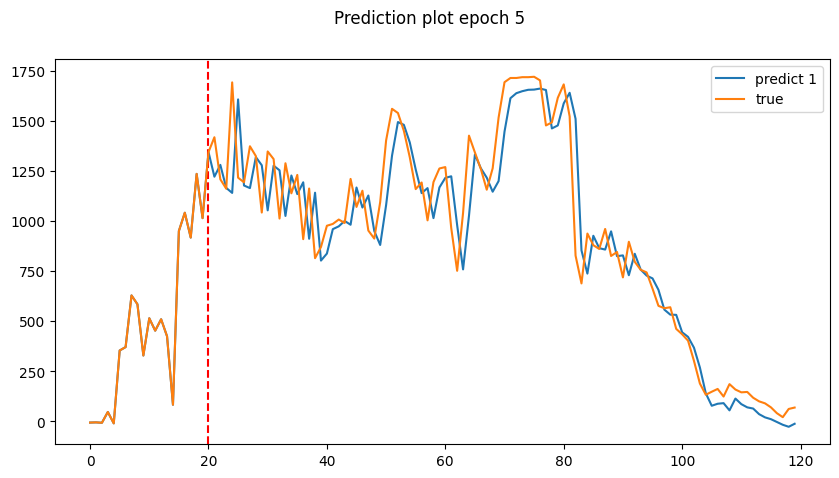

In [ ]:
all_data_denorm = np.round(scaler.inverse_transform(all_data.reshape(all_data.size,1)))

fig, (ax1) = plt.subplots(1, 1,figsize=(10,5), sharex=True, sharey=True)
fig.suptitle(f'Prediction plot epoch {epoch_num}')
for i,C in enumerate(D):
  d_denorm = np.round(scaler.inverse_transform(C.reshape(C.size,1)))
  ax1.plot(d_denorm, label=f'predict {i+1}')
ax1.axvline(input_step-1, ls='dashed', c='r')
ax1.plot(all_data_denorm, label='true')
ax1.legend()

plt.show()

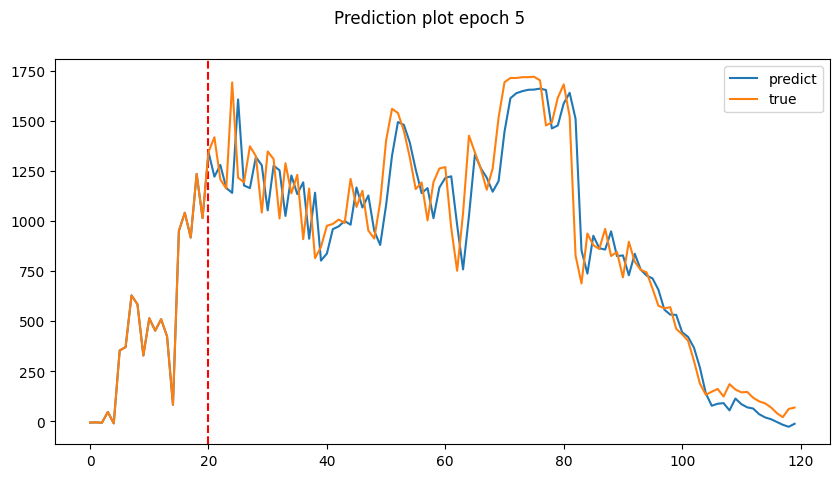

In [ ]:
all_data_denorm = np.round(scaler.inverse_transform(all_data.reshape(all_data.size,1)))
temp_1=None

fig, (ax1) = plt.subplots(1, 1,figsize=(10,5), sharex=True, sharey=True)
fig.suptitle(f'Prediction plot epoch {epoch_num}')
for i,C in enumerate(D):
  temp_1 = np.round(scaler.inverse_transform(C.reshape(C.size,1)))

ax1.plot(temp_1, label=f'predict')
ax1.axvline(input_step-1, ls='dashed', c='r')
ax1.plot(all_data_denorm, label='true')
ax1.legend()

plt.show()

In [ ]:
from numpy import savetxt
savetxt('content/BAB 6/modelLain/Wind_trans_adam.csv', temp_1, delimiter=',')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
MAPE = []
for ind, d in enumerate(D):
    d_denorm = np.round(scaler.inverse_transform(d.reshape(d.size,1)))
    print(f"Error Pred {ind+1}")
    print(f"MAPE\t : {np.round(mean_absolute_percentage_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:])*100,5)}")
    print(f"MAE\t : {np.round(mean_absolute_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:]),5)}")
    print(f"MSE\t : {np.round(mean_squared_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:]),5)}")
    print(f"RMSE\t : {np.round(np.sqrt(mean_squared_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:])),5)}\n")
    MAPE.append(np.round(mean_absolute_percentage_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:])*100,5))
print("Rata-rata MAPE ",np.round(np.mean(MAPE),5))

Error Pred 1
MAPE	 : 22.13762
MAE	 : 121.32323
MSE	 : 28810.47475
RMSE	 : 169.73649

Rata-rata MAPE  22.13762


In [ ]:
raise TimeoutError("Stopped")

## Learning Rate Range Test

In [ ]:
lrrt_model = Transformer(device, d_model, in_dim, N_enc, N_dec, h_enc, h_dec, ff_hidnum, hid_pre, hid_post, dropout_pre, dropout_post, dropout_model, norm_first)
lrrt_model=lrrt_model.to(device)
state_before_train_lrrt=lrrt_model.state_dict().copy()
fix_seed(30)


In [ ]:
def find_lr(model, train_loader, criterion, optimizer, init_lr=1e-6, final_lr=1e-1, num_epochs=100):
    device = next(model.parameters()).device
    lrs = np.logspace(np.log10(init_lr), np.log10(final_lr), num=num_epochs)
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        current_lr = lrs[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
            print(param_group['lr'])

        for iter, (x, y, tgt) in enumerate(train_loader):
            x, y, tgt = x.to(device), y.to(device), tgt.to(device)
            tgt = tgt[:,:,0]

            out = model(x, y)
            loss = criterion(out, tgt)
            out_npy = out.to('cpu').detach().numpy().copy()
            tgt_npy = tgt.to('cpu').detach().numpy().copy()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        val_loss = check_data(device, val_loader, model, criterion)
        val_losses.append(val_loss)# MSE
        losses.append(loss.item())
        print("epoch {} losses {}".format(epoch,loss.item()))

    return lrs, losses,val_losses

In [ ]:
optimizer = optim.SGD(lrrt_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
learning_rates, losses,val_losses = find_lr(lrrt_model, train_loader, criterion, optimizer)
fix_seed(30)

1e-06


epoch 0 losses 1.9487667083740234
1.1233240329780266e-06
epoch 1 losses 1.9328036308288574
1.261856883066021e-06
epoch 2 losses 1.9150373935699463
1.4174741629268049e-06
epoch 3 losses 1.8952864408493042
1.592282793341094e-06
epoch 4 losses 1.8733545541763306
1.788649529057435e-06
epoch 5 losses 1.8490324020385742
2.0092330025650458e-06
epoch 6 losses 1.8221111297607422
2.2570197196339214e-06
epoch 7 losses 1.792354941368103
2.5353644939701112e-06
epoch 8 losses 1.7595319747924805
2.848035868435799e-06
epoch 9 losses 1.723408818244934
3.1992671377973847e-06
epoch 10 losses 1.6837491989135742
3.5938136638046257e-06
epoch 11 losses 1.6402833461761475
4.037017258596558e-06
epoch 12 losses 1.5911394357681274
4.534878508128582e-06
epoch 13 losses 1.5332530736923218
5.0941380148163755e-06
epoch 14 losses 1.4707690477371216
5.72236765935022e-06
epoch 15 losses 1.4036391973495483
6.4280731172843194e-06
epoch 16 losses 1.3319171667099
7.220809018385457e-06
epoch 17 losses 1.2557531595230103
8.1

In [ ]:
train_loss_np = np.array(losses)
val_loss_np = np.array(val_losses)

Learning rate terbaik: 0.07054802310718646, pada epoch 96 dengan loss 3.877109702443704e-05


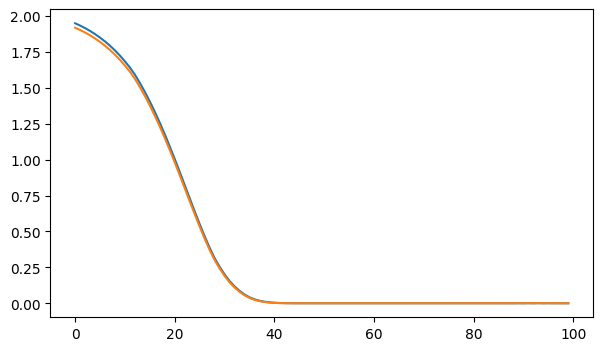

In [ ]:
# Simpan nilai learning rate dengan loss terkecil menggunakan MAE
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(train_loss_np, label="train")
ax.plot(val_loss_np, label="validation")
best_lr = learning_rates[np.argmin(losses)]
best_epoch = np.argmin(losses)
best_loss = np.min(losses)
print(f"Learning rate terbaik: {best_lr}, pada epoch {best_epoch} dengan loss {best_loss}")

Stopper

In [ ]:
stopper
raise NameError()

NameError: name 'stopper' is not defined

## CLR

In [ ]:
import numpy as np

In [ ]:
best_lr=0.00689261

In [ ]:
clr_model = Transformer(device, d_model, in_dim, N_enc, N_dec, h_enc, h_dec, ff_hidnum, hid_pre, hid_post, dropout_pre, dropout_post, dropout_model, norm_first)
clr_model=clr_model.to(device)
optimizer = optim.SGD(clr_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
fix_seed(30)
# raise KeyError()

### Cosine CLR

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler
class CosineCyclicLR(_LRScheduler):
    def __init__(self, optimizer, base_lr, max_lr, step_size, last_epoch=-1):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        super(CosineCyclicLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        cycle = math.floor(1 + self.last_epoch / (2 * self.step_size))
        x = abs(self.last_epoch / self.step_size - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * (1 + math.cos(math.pi * x)) / 2
        return [lr for _ in self.base_lrs]

### Improve Cosine LR

In [ ]:
data=pd.read_csv("Data/ETTm2.csv")
data=data.dropna(subset=["OT"])
data_ett=data["OT"].to_numpy()
data_ett_var=np.var(data_ett)

In [ ]:
data_ett_var

141.28771749571416

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler
class NovelCosineCyclicLR(_LRScheduler):
    def __init__(self, optimizer, base_lr, max_lr, step_size, batch_variance,last_epoch=-1):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.data=None
        self.batch_variance=batch_variance
        super(NovelCosineCyclicLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        cycle = math.floor(1 + self.last_epoch / (2 * self.step_size))
        x = abs(self.last_epoch / self.step_size - 2 * cycle + 1)
        novelty_factor = self.calculate_novelty_factor()
        lr = [self.base_lr + (self.max_lr - self.base_lr) * (1 + math.cos(math.pi * x)) / 2 * bv for bv in self.batch_variance]
        return lr

    def calculate_novelty_factor(self):
        if self.novelty_metric == 'variance':
            # Example: Calculate variance and normalize
            data = data_ett_var # Replace this with your actual data retrieval
            novelty_value = data
        elif self.novelty_metric == 'mean':
            # Example: Calculate mean and normalize
            data = self.get_data()  # Replace this with your actual data retrieval
            novelty_value = np.mean(data)
        # Add more cases for other metrics as needed

        return 1 + self.novelty_weight * novelty_value

    def get_data(self):
        # ett M2
        self.data=data_ett
        return self.data

# Get var for each batch

In [ ]:
var_per_batch=[]
for iter, (x, y, tgt) in enumerate(train_loader):
    step_var=[]
    for items in x:
        test=items[:,0]
        # print(test.shape)
        # print()
        step_var.append(torch.var(test))
        # print()
    # tensor_batch_step_var=torch.cat(step_var,dim=1)
    tensor_batch_step_var = torch.FloatTensor(step_var)
    mean_step=torch.mean(tensor_batch_step_var)
    print("Rata-rata varians untuk step {} adalah {}".format(iter,mean_step))
    var_per_batch.append(mean_step)

# var_per_batch=torch.mul(var_per_batch,0.01)


Rata-rata varians untuk step 0 adalah 0.00019131162844132632
Rata-rata varians untuk step 1 adalah 0.00021116390416864306
Rata-rata varians untuk step 2 adalah 0.00017902969557326287
Rata-rata varians untuk step 3 adalah 0.0002028408198384568
Rata-rata varians untuk step 4 adalah 0.0001656918611843139
Rata-rata varians untuk step 5 adalah 0.0001818318123696372
Rata-rata varians untuk step 6 adalah 0.0002390822337474674
Rata-rata varians untuk step 7 adalah 0.00018279647338204086
Rata-rata varians untuk step 8 adalah 0.00024956249399110675
Rata-rata varians untuk step 9 adalah 0.00019719697593245655
Rata-rata varians untuk step 10 adalah 0.00018311820167582482
Rata-rata varians untuk step 11 adalah 0.00018570739484857768
Rata-rata varians untuk step 12 adalah 0.00025573940365575254
Rata-rata varians untuk step 13 adalah 0.00018518982687965035
Rata-rata varians untuk step 14 adalah 0.00017527553427498788
Rata-rata varians untuk step 15 adalah 0.0001815345895010978
Rata-rata varians untuk

In [ ]:
# import torch.optim.lr_scheduler as lr_scheduler
best_both_loss_clr = (np.inf, np.inf)
best_train_epoch_clr = 0
best_val_epoch_clr = 0
best_both_epoch_clr = 0
best_train_loss_clr = np.inf
best_val_loss_clr = np.inf


def train_with_clr(model, train_loader, criterion, optimizer, num_epochs,base_lr, max_lr_multiplier, cycle_size):
    
    # scheduler = CosineCyclicLR(optimizer, base_lr=base_lr,max_lr=(base_lr*max_lr_multiplier), step_size=cycle_size)
    scheduler = NovelCosineCyclicLR(optimizer, base_lr=base_lr,max_lr=(base_lr*max_lr_multiplier),novelty_weight=0.01,novelty_metric="variance",step_size=cycle_size,batch_variance=var_per_batch)
    train_losses = []
    val_losses = []

    global best_both_loss_clr
    global best_train_epoch_clr
    global best_val_epoch_clr
    global best_both_epoch_clr
    global best_train_loss_clr
    global best_val_loss_clr
    global max_iteration_clr
    global data_ett_var
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        tgt_log_train = np.zeros((1,predict_step))
        pred_log_train = np.zeros((1,predict_step))

        for iter, (x, y, tgt) in enumerate(train_loader):
            x, y, tgt = x.to(device), y.to(device), tgt.to(device)
            
            
            tgt = tgt[:,:,0]
            model.train()
            
            out = model(x, y)
            loss = criterion(out, tgt)
            out_npy = out.to('cpu').detach().numpy().copy()
            tgt_npy = tgt.to('cpu').detach().numpy().copy()
            pred_log_train = np.concatenate([pred_log_train, out_npy], axis=0)
            tgt_log_train = np.concatenate([tgt_log_train, tgt_npy], axis=0)
            # print("step {}, lr {}".format(iter,optimizer.param_groups[0]['lr']))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()  # Update learning rate
            total_train_loss += loss.item()
            # print(data_ett_var)
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

        if epoch == 0:
            max_iteration_clr = iter + 1
        train_losses.append(loss.item())
        val_loss = check_data(device, val_loader, clr_model, criterion)
        val_losses.append(val_loss)# MSE

        # print("*************validation******************")
        print("epoch : {}, val_loss : {}, current lr {} ,rmse : {}\n".format(epoch,val_loss, scheduler.get_lr()[0], math.sqrt(val_loss)))
        # print("epoch : {}, val_loss : {}, current lr {} ,rmse : {}\n".format(epoch,val_loss, optimizer.param_groups[0]['lr'], math.sqrt(val_loss)))

        #   save low train loss model
        if loss < best_train_loss_clr:
            best_train_loss_clr = loss
            best_train_epoch_clr = epoch
            torch.save(model.state_dict(), os.path.join(model_path, "best_train_loss_model_clr.model"))

        # save low val loss model
        if val_loss < best_val_loss_clr:
            best_val_loss_clr = val_loss
            best_val_epoch_clr = epoch
            torch.save(model.state_dict(), os.path.join(model_path, "best_val_loss_model_clr.model"))

        # save both loss model
        if loss < best_train_loss_clr and val_loss < best_val_loss_clr:
            best_both_loss_clr = (loss, val_loss)
            best_both_epoch_clr = epoch
            torch.save(model.state_dict(), os.path.join(model_path, "best_both_loss_model_clr.model"))

        # save model
        if epoch % save_each == 0 or epoch == max_epoch - 1:
            torch.save(model.state_dict(), os.path.join(model_path, '{}_epoch_clr.model'.format(epoch)))
    return train_losses,val_losses
# Contoh penggunaan:
train_loss_clr,val_loss_clr=train_with_clr(clr_model, train_loader, criterion, optimizer, num_epochs=100,base_lr=best_lr , max_lr_multiplier=8, cycle_size=25)

epoch : 0, val_loss : 0.08180321409152104, current lr 0.006892646197229624 ,rmse : 0.2860126117700425



epoch : 1, val_loss : 0.030950074155743305, current lr 0.0068927546963095665 ,rmse : 0.17592633161566038

epoch : 2, val_loss : 0.005006490275263786, current lr 0.00689293397590518 ,rmse : 0.07075655641185336

epoch : 3, val_loss : 0.001003970333840698, current lr 0.006893180776387453 ,rmse : 0.03168549090420879

epoch : 4, val_loss : 0.000704461363896441, current lr 0.006893491372466087 ,rmse : 0.026541691051936402

epoch : 5, val_loss : 0.0006238428401187635, current lr 0.006893860641866922 ,rmse : 0.024976846080295316

epoch : 6, val_loss : 0.0005749452617377616, current lr 0.006894283462315798 ,rmse : 0.023978016217730807

epoch : 7, val_loss : 0.0005370693778296789, current lr 0.006894751917570829 ,rmse : 0.02317475734133324

epoch : 8, val_loss : 0.0004973393739559329, current lr 0.006895259954035282 ,rmse : 0.022301107011893667

epoch : 9, val_loss : 0.0004794854724493164, current lr 0.006895798724144697 ,rmse : 0.021897156720663905

epoch : 10, val_loss : 0.0004857379759554393,

In [ ]:
train_loss_np = np.array(train_loss_clr)
val_loss_np = np.array(val_loss_clr)

In [ ]:
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(train_loss_np, label="train")
ax.plot(val_loss_np, label="validation")
plt.title("MSE Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
print("Loss terendah {}, pada epoch {}".format(np.min(train_loss_clr),np.argmin(train_loss_clr)))
print("Validation Loss terendah {}, pada epoch {}".format(np.min(val_loss_clr),np.argmin(val_loss_clr)))

Loss terendah 0.00011116047244286165, pada epoch 75
Validation Loss terendah 0.00029363683111464174, pada epoch 89


In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

def print_clr_schedule(optimizer, base_lr, max_lr_multiplier, num_epochs, cycle_size):
    scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=base_lr*max_lr_multiplier, step_size_up=cycle_size, cycle_momentum=False, mode='triangular2')

    learning_rates = []

    for epoch in range(num_epochs):
        current_lr = scheduler.get_lr()[0]
        print(f'Epoch [{epoch+1}/{num_epochs}], Learning Rate: {current_lr:.6f}')
        learning_rates.append(current_lr)
        scheduler.step()

    # Extend the learning_rates list to include the descending phase
    learning_rates += learning_rates[-2:0:-1]

    # Plot learning rate schedule
    plt.plot(range(1, len(learning_rates)+1), learning_rates)
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Triangular Learning Rate Schedule')
    plt.show()

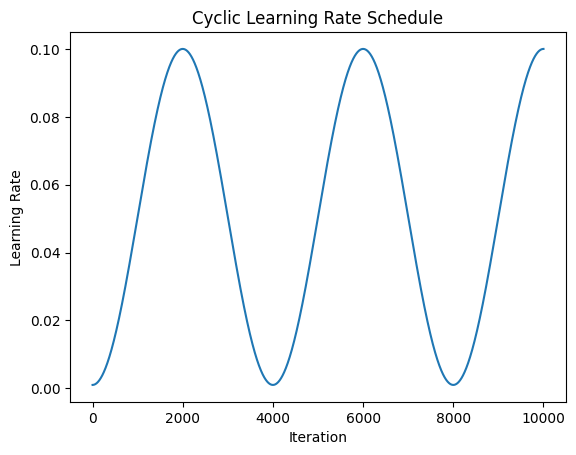

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def cyclic_lr_cosine(base_lr, max_lr, step_size, iteration):
    cycle = np.floor(1 + iteration / (2 * step_size))
    x = np.abs(iteration / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * (1 + np.cos(np.pi * x)) / 2
    return lr

# Tentukan parameter CLR
base_lr = 0.001
max_lr = 0.1
step_size = 2000

# Simulasikan iterasi
num_iterations = 10000
learning_rates = []

for iteration in range(1, num_iterations + 1):
    current_lr = cyclic_lr_cosine(base_lr, max_lr, step_size, iteration)
    learning_rates.append(current_lr)

# Plot learning rate schedule
plt.plot(range(1, num_iterations + 1), learning_rates)
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Cyclic Learning Rate Schedule')
plt.show()

In [ ]:
# print_clr_schedule(optimizer, base_lr=1e-2, max_lr_multiplier=8, num_epochs=100, cycle_size=20)

## Testing

Load Data

In [ ]:
def make_dataloader(data, input_step, predict_step, batch_size=1):
    dataset = Dataset(data, input_step, predict_step)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataset, dataloader

In [ ]:
torch.set_printoptions(precision=5, sci_mode=False)
np.set_printoptions(precision=5, suppress=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
test_set, test_loader = make_dataloader(test, input_step, predict_step, batch_size=600)
all_data = test_set.data[:,0]

In [ ]:
test_set.data

tensor([-0.76429, -0.77144, -0.77144, -0.77857])

In [ ]:
test.size

120

Load Model & State

In [ ]:
epoch_num = best_val_epoch_clr
print(epoch_num)
par_path = os.path.join(model_path, "best_val_loss_model_clr.model")

89


In [ ]:
net = Transformer(device, d_model, in_dim, N_enc, N_dec, h_enc, h_dec, ff_hidnum, hid_pre, hid_post, dropout_pre, dropout_post, dropout_model, norm_first)

# load parameter
if device == torch.device("cpu"):
  net.load_state_dict(torch.load(par_path, map_location=torch.device("cpu")))
else:
  net.load_state_dict(torch.load(par_path,map_location=torch.device(device)))

Testing

In [ ]:
net.eval()

pred_list = np.zeros((1, predict_step))
for iter, (x, y, tgt) in enumerate(test_loader):
    tgt = tgt[:,:,0]

    out = net.generate(x, tgt.shape[1], y[:,[0],:])
    out = out.to('cpu').detach().numpy().copy()

    pred_list = np.concatenate([pred_list, out], axis=0)

pred_list = pred_list[1:]
D = []
for i in range(predict_step):
    tmp = np.concatenate([all_data[:(input_step+i)], pred_list[:,i], all_data[(all_data.shape[0]-(predict_step - (i + 1))):]])
    D.append(tmp)

for step_num, tmp_data in enumerate(D):
    n = step_num + 1

    np.save(os.path.join(test_result_path, "pred{}_epoch{}".format(n, epoch_num)), pred_list[:,[step_num]])
    np.save(os.path.join(test_result_path, "tgt{}_epoch{}".format(n, epoch_num)), tgt[:,[step_num]])

Plot

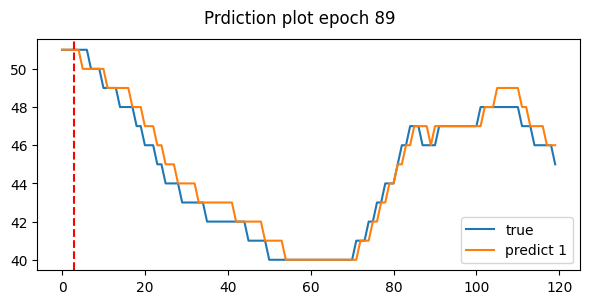

In [ ]:
all_data_denorm = np.round(scaler.inverse_transform(all_data.reshape(all_data.size,1)))

fig, (ax1) = plt.subplots(1, 1,figsize=(7,3), sharex=True, sharey=True)
fig.suptitle(f'Prdiction plot epoch {epoch_num}')

for ind, d in enumerate(D):
  d_denorm = np.round(scaler.inverse_transform(d.reshape(d.size,1)))

  exec("ax"+str(ind+1)+".plot(all_data_denorm, label='true')")
  exec("ax"+str(ind+1)+".plot(d_denorm, label=f'predict {ind+1}')")
  exec("ax"+str(ind+1)+".axvline(input_step+ind-1,ls='dashed',c='r')")
  # exec("ax"+str(ind+1)+".set_title(f'predict {ind+1}')")
  exec("ax"+str(ind+1)+".legend()")

## Error

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
for ind, d in enumerate(D):
    d_denorm = np.round(scaler.inverse_transform(d.reshape(d.size,1)))
    print(f"Error Pred {ind+1}")
    print(f"MAPE\t : {mean_absolute_percentage_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:])*100}")
    print(f"MAE\t : {mean_absolute_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:])}")
    print(f"MSE\t : {mean_squared_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:])}")
    print(f"RMSE\t : {np.sqrt(mean_squared_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:]))}\n")

Error Pred 1
MAPE	 : 1.1017359510999696
MAE	 : 0.49137931034482757
MSE	 : 0.49137931034482757
RMSE	 : 0.7009845293191767



In [ ]:
raise KeyError()

# LSTM

## Library

In [431]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Model

In [432]:
class LSTM(nn.Module):

    def __init__(self, input_size, num_classes, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

## Dataset

In [433]:
# data_path = 'https://data.covid19.go.id/public/api/update.json'
# data_path = 'update_22-3-2022.json'
import requests
import json
import pandas as pd

def load_data(data_path, from_api=True, dataset_len=None):
    # data = requests.get(data_path).json() if from_api else pd.read_json(data_path)

    # df = pd.DataFrame(data['update']['harian'])[['key','jumlah_positif']]
    # df.key = pd.to_datetime(df.key, unit='ms')

    # for i, row in enumerate(df.jumlah_positif):
    #     df.loc[i,['jumlah_positif']] = row.get('value')

    data=pd.read_csv(data_path)
    df=data[["V1","V2"]]
    df = df.set_index('V1')

    # data=pd.read_csv(data_path)
    # df=data[["date","OT"]]
    # df = df.set_index('date')

    # data=pd.read_csv(data_path)
    # data = data.rename(columns={data.columns[0]: 'Date'}) 
    # data=data.dropna(subset=["ActivePower"])
    # # data=data[["Date","ActivePower","WindSpeed"]]
    # df=data[["Date","ActivePower"]]
    # df = df.set_index('Date')

    # df = df.set_index('key')
    data_len = df.shape[0]
    numpy_use = df.to_numpy() if dataset_len == None else df[:dataset_len].to_numpy()

    return numpy_use

In [434]:
# data = load_data('update 12-05-2022.json', from_api=False, dataset_len=750)
data = load_data('Data/m4/Daily-train.csv')

In [435]:
data.size

4227

In [436]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler(feature_range=(-1, 1))
training_data = sc.fit_transform(data)

seq_length = 7
x, y = sliding_windows(training_data, seq_length)

test_size = 120
train_size = int(len(y) - test_size)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))



testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


In [438]:
# print(f"Model is on device: {next(lstm.parameters()).device}")
print(f"Input data is on device: {trainX.device}")

Input data is on device: cpu


## Training

In [441]:
import torch.utils.data as data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
learning_rate = 0.001

input_size = 1
hidden_size = 16
num_layers = 1

num_classes = 1
loader = data.DataLoader(data.TensorDataset(trainX, trainY), shuffle=True, batch_size=1378)

lstm = LSTM(input_size, num_classes, hidden_size, num_layers)
# lstm = lstm.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, betas=(0.9,0.98))


base_lr=0.0002782559402207126
max_lr_multiplier=7
cycle_size=15

# hidden = None
# scheduler = CosineCyclicLR(optimizer, base_lr=base_lr,max_lr=(base_lr*max_lr_multiplier), step_size=cycle_size)
# scheduler = BatchVarCosineCyclicLR(optimizer, base_lr=base_lr, max_lr=(base_lr*max_lr_multiplier), step_size=cycle_size)
# Train the model
for epoch in range(num_epochs):
    # print(trainX.shape)
    # outputs, hidden = rnn(trainX, hidden)
    for X_batch, y_batch in loader:
        # X_batch,y_batch=X_batch.to(device),y_batch.to(device)
        y_pred = lstm(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        # scheduler.set_batch_data(X_batch) 
        loss.backward()
        optimizer.step()
        # scheduler.step()

    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.25142
Epoch: 1, loss: 1.20088
Epoch: 2, loss: 1.14834
Epoch: 3, loss: 1.09720
Epoch: 4, loss: 1.04659
Epoch: 5, loss: 0.99829
Epoch: 6, loss: 0.94618
Epoch: 7, loss: 0.89592
Epoch: 8, loss: 0.84496
Epoch: 9, loss: 0.79436
Epoch: 10, loss: 0.73944
Epoch: 11, loss: 0.68780
Epoch: 12, loss: 0.63080
Epoch: 13, loss: 0.57347
Epoch: 14, loss: 0.51498
Epoch: 15, loss: 0.45536
Epoch: 16, loss: 0.39432
Epoch: 17, loss: 0.33341
Epoch: 18, loss: 0.27326
Epoch: 19, loss: 0.21475


## Testing



In [442]:
testX.shape

torch.Size([120, 7, 1])

In [443]:
lstm.eval()
train_predict = lstm(testX)

data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = np.round(sc.inverse_transform(data_predict))
np.savetxt('data_predict.csv', data_predict, delimiter=',')

dataY_plot = np.round(sc.inverse_transform(dataY_plot))
np.savetxt('dataY_plot.csv', dataY_plot, delimiter=',')

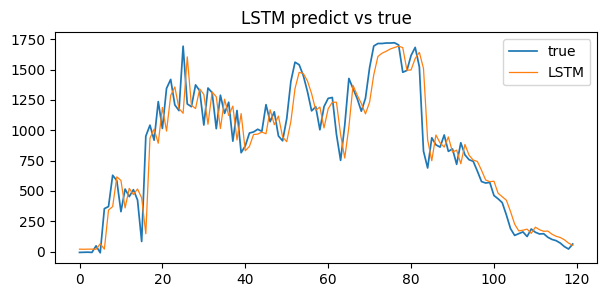

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(dataY_plot, label="true", linewidth=1.25)
ax.plot(data_predict, label="LSTM", linewidth=0.9)
# df_label=pd.read_csv("data/m4/Daily-train.csv")
# interval=500

# df=data[["V1"]]
# df = df.set_index('V1')
# plt.xticks([x for items in df])
# plt.xticks(df_label['V1'][::interval])
plt.title("LSTM predict vs true")
plt.legend()
plt.show()

In [ ]:
from numpy import savetxt
savetxt('content/BAB 6/modelLain/WIND_Lstm_BatchVar.csv', data_predict, delimiter=',')

## Error

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
print(f"Error Pred")
print(f"MAPE\t : {mean_absolute_percentage_error(data_predict, dataY_plot)*100}")
print(f"MAE\t : {mean_absolute_error(data_predict, dataY_plot)}")
print(f"MSE\t : {mean_squared_error(data_predict, dataY_plot)}")
print(f"RMSE\t : {np.sqrt(mean_squared_error(data_predict, dataY_plot))}\n")

Error Pred
MAPE	 : 41.233596205711365
MAE	 : 131.14166259765625
MSE	 : 35302.2734375
RMSE	 : 187.8889923095703



In [ ]:
raise TimeoutError("Test")

# RNN

## Library

In [444]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Model

In [445]:
class RNN(nn.Module):
    def __init__(self, input_dim, output_dim,  hidden_dim, layer_dim):
        super(RNN, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim)
        # batch_dim = number of samples per batch
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 10
        # out[:, -1, :] --> 100, 10 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

## Dataset

In [522]:
# data_path = 'https://data.covid19.go.id/public/api/update.json'
# data_path = 'update_22-3-2022.json'
import requests
import json
import pandas as pd

def load_data(data_path, from_api=True, dataset_len=None):
    # data = requests.get(data_path).json() if from_api else pd.read_json(data_path)

    # df = pd.DataFrame(data['update']['harian'])[['key','jumlah_positif']]
    # df.key = pd.to_datetime(df.key, unit='ms')

    # for i, row in enumerate(df.jumlah_positif):
    #     df.loc[i,['jumlah_positif']] = row.get('value')
    # data=pd.read_csv(data_path)
    # df=data[["V1","V2"]]
    # df = df.set_index('V1')

    data=pd.read_csv(data_path)
    df=data[["date","OT"]]
    df = df.set_index('date')

    # data=pd.read_csv(data_path)
    # data = data.rename(columns={data.columns[0]: 'Date'}) 
    # data=data.dropna(subset=["ActivePower"])
    # # data=data[["Date","ActivePower","WindSpeed"]]
    # df=data[["Date","ActivePower"]]
    # df = df.set_index('Date')
    
    # df = df.set_index('key')
    data_len = df.shape[0]
    numpy_use = df.to_numpy() if dataset_len == None else df[:dataset_len].to_numpy()

    return numpy_use

In [523]:
# data = load_data('update 12-05-2022.json', from_api=False, dataset_len=750)
data = load_data('data/ETTm2.csv')

In [524]:
data.size

69680

In [525]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler(feature_range=(-1, 1))
training_data = sc.fit_transform(data)

seq_length = 7
x, y = sliding_windows(training_data, seq_length)

test_size = 120
train_size = int(len(y) - test_size)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Training

In [526]:
import torch.utils.data as data
num_epochs = 1
learning_rate = 0.0002782559402207126

input_size = 1
hidden_size = 16
num_layers = 1

num_classes = 1

rnn = RNN(input_size, num_classes, hidden_size, num_layers)

loader = data.DataLoader(data.TensorDataset(trainX, trainY), shuffle=True, batch_size=67)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate, betas=(0.9,0.98))

# hidden = None

base_lr=0.0002782559402207126
max_lr_multiplier=8
cycle_size=15

scheduler = CosineCyclicLR(optimizer, base_lr=base_lr,max_lr=(base_lr*max_lr_multiplier), step_size=cycle_size)
# scheduler = BatchVarCosineCyclicLR(optimizer, base_lr=base_lr, max_lr=(base_lr*max_lr_multiplier), step_size=cycle_size)
# Train the model
for epoch in range(num_epochs):
    # print(trainX.shape)
    # outputs, hidden = rnn(trainX, hidden)
    for X_batch, y_batch in loader:
        y_pred = rnn(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        # scheduler.set_batch_data(X_batch) 
        loss.backward()
        optimizer.step()
        scheduler.step()

    
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.00009


## Testing



In [527]:
testX.shape

torch.Size([120, 7, 1])

In [528]:
rnn.eval()
train_predict = rnn(testX)

data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = np.round(sc.inverse_transform(data_predict))
np.savetxt('data_predict.csv', data_predict, delimiter=',')

dataY_plot = np.round(sc.inverse_transform(dataY_plot))
np.savetxt('dataY_plot.csv', dataY_plot, delimiter=',')

In [529]:
dataY_plot = testY.data.numpy()
dataY_plot = np.round(sc.inverse_transform(dataY_plot))
np.savetxt('dataY_plot.csv', dataY_plot, delimiter=',')

In [530]:
from numpy import loadtxt
# m4_uni=loadtxt("content/BAB 6/multi/M4_1.csv")
m4_uni=loadtxt("content/BAB 6/modelLain/ETT_trans_cyclic.csv")
m4_LSTM=loadtxt("content/BAB 6/modelLain/ETT_lstm_batchVar.csv")
m4_RNN=loadtxt("content/BAB 6/modelLain/ETT_rnn_Adam.csv")

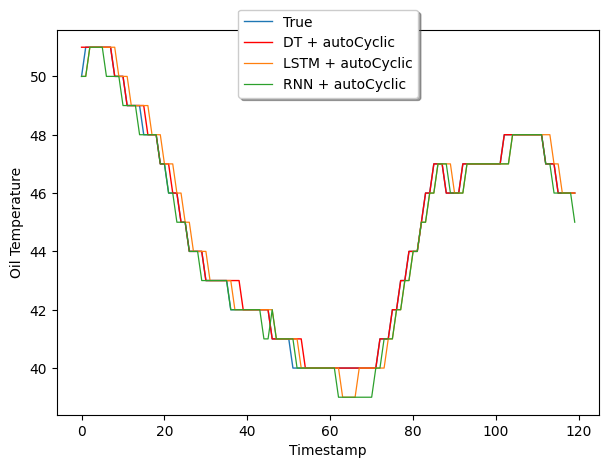

In [536]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(dataY_plot, label="True", linewidth=1)
# ax.plot(data_predict, "r",label="RNN", linewidth=0.9)
# plt.xticks(np.arange(0,61,4),[d.strftime('%Y-%m-%d') for d in pd.date_range('2022-01-21', periods=16, freq='4D')], rotation=45)
# plt.title("RNN predict vs true")
plt.ylabel("Oil Temperature")

plt.xlabel("Timestamp")
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07),
          ncol=1, fancybox=True, shadow=True)
plt.show()

In [ ]:
from numpy import savetxt
savetxt('content/BAB 6/modelLain/WIND_rnn_BatchVar.csv', data_predict, delimiter=',')

## Error

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
print(f"Error Pred")
print(f"MAPE\t : {mean_absolute_percentage_error(data_predict, dataY_plot)*100}")
print(f"MAE\t : {mean_absolute_error(data_predict, dataY_plot)}")
print(f"MSE\t : {mean_squared_error(data_predict, dataY_plot)}")
print(f"RMSE\t : {np.sqrt(mean_squared_error(data_predict, dataY_plot))}\n")

Error Pred
MAPE	 : 39.181122183799744
MAE	 : 130.2083282470703
MSE	 : 35110.66015625
RMSE	 : 187.37838745117188

